In [1]:
%reset -s -f

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from malware_ml.visualization import plot_roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
path_to_data = '/volumes/transcend/data/train.csv'
data = pd.read_csv(path_to_data)

In [3]:
models = [
    DecisionTreeClassifier(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB()
]

In [4]:
train_val_data, hold_data = train_test_split(data, test_size=0.02, random_state=1)
train_data, val_data = train_test_split(train_val_data, test_size=0.3, random_state=1)

In [5]:
hold_data.to_csv('/volumes/transcend/data/hold_data.csv', index=False)

In [6]:
train_data.to_csv('/volumes/transcend/data/train_data.csv', index=False)
val_data.to_csv('/volumes/transcend/data/val_data.csv', index=False)

In [4]:
train_data = pd.read_csv('/volumes/transcend/data/train_data.csv')
val_data = pd.read_csv('/volumes/transcend/data/val_data.csv')

/Users/emrys/repos/safeboardml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


насчет предупреждения: при добавлении параметра low_memory=False бесконечно долго длится процесс чтения файла, пришлось его убрать

In [5]:
columns = train_data.columns

### подготовка даты: нужно избавиться от inf, nan, и закодировать данные типа str

In [6]:
from custom import preprocessingData

In [7]:
preprocessingData(train_data)

In [8]:
preprocessingData(val_data)

### сравним cross_val_score для трёх выбранных моделей, но на ограниченной выборке, иначе очень долго (или лучше это вообще убрать?)

In [21]:
for model in models:
    %time print(model, '\nAccuracy:', cross_val_score(model, train_data.iloc[:999999, :-1], train_data.iloc[:999999, -1], cv=3).mean())
    print()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') 
Accuracy: 0.5713375713375713
CPU times: user 2min 35s, sys: 6.13 s, total: 2min 41s
Wall time: 2min 43s

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001) 
Accuracy: 0.5177155177155176
CPU times: user 1min 9s, sys: 13.4 s, total: 1min 23s
Wall time: 1min

GaussianNB(priors=None, var_smoothing=1e-09) 
Accuracy: 0.529078529078529
CPU times: user 8.25 s, sys: 8.5 s, total: 16.7 s
Wall time: 19.3 s



### обучение моделей и оценка качества

In [15]:
models[0].fit(train_data[columns[:-1]], train_data[columns[-1]])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
prediction = models[0].predict_proba(val_data[columns[:-1]])[:,1]

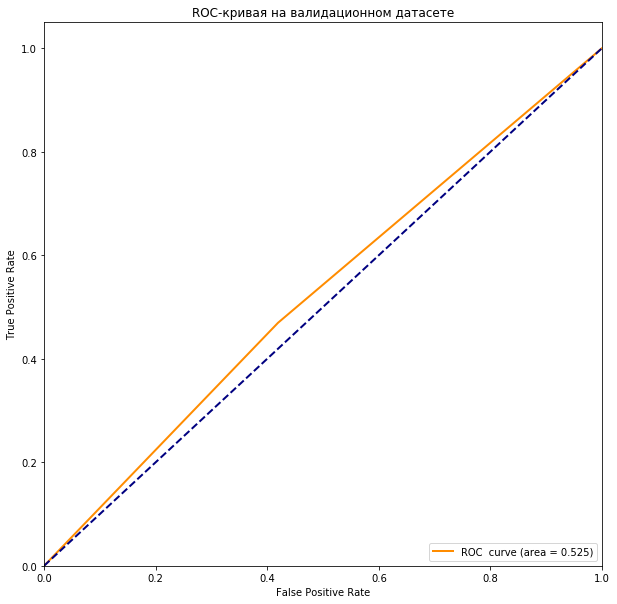

In [16]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[columns[-1]],
               pred=prediction,
               name='ROC-кривая на валидационном датасете')

In [17]:
DecisionTreeClassifier_path = './models/DTC.pkl'
pickle.dump(models[0], open(DecisionTreeClassifier_path, 'wb'))

In [12]:
models[1].fit(train_data[columns[:-1]], train_data[columns[-1]])

/Users/emrys/repos/safeboardml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [14]:
prediction = models[1].predict_proba(val_data[columns[:-1]])[:,1]

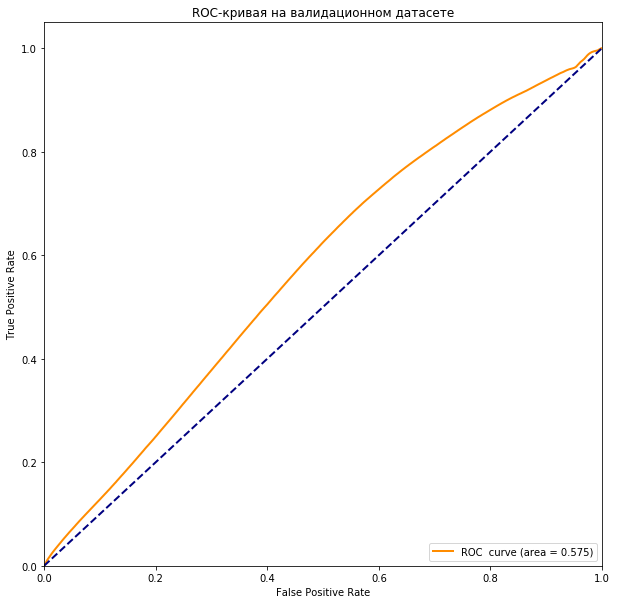

In [15]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[columns[-1]],
               pred=prediction,
               name='ROC-кривая на валидационном датасете')

In [16]:
QuadraticDiscriminantAnalysis_path = './models/QDA.pkl'
pickle.dump(models[1], open(QuadraticDiscriminantAnalysis_path, 'wb'))

In [16]:
models[2].fit(train_data[columns[:-1]], train_data[columns[-1]])

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
prediction = models[2].predict_proba(val_data[columns[:-1]])[:,1]

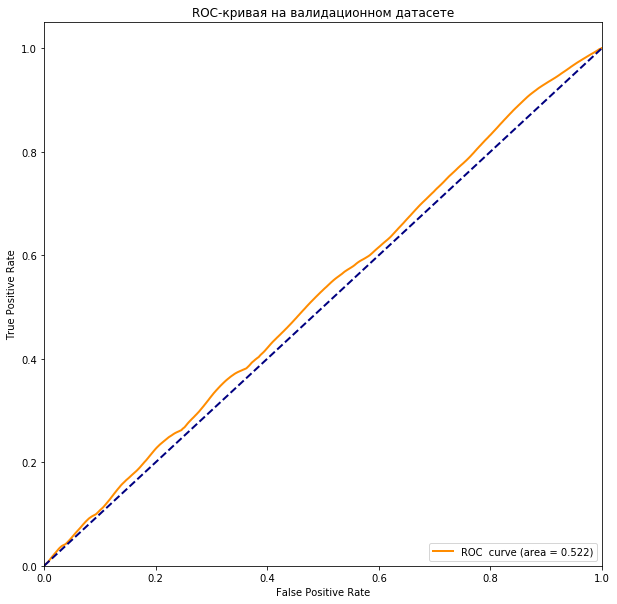

In [17]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[columns[-1]],
               pred=prediction,
               name='ROC-кривая на валидационном датасете')

In [18]:
GaussianNB_path = './models/GNB.pkl'
pickle.dump(models[2], open(GaussianNB_path, 'wb'))

### из трех рассмотренных моделей лучший результат показала модель QuadraticDiscriminantAnalysis

### попробуем также использовать линейную регрессию и подобрать для неё гиперпараметры

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid = dict()
param_grid['C'] = np.power(10.0, np.arange(-2, 2))
param_grid['max_iter'] = range(100,501,100)
param_grid['penalty'] = ['l1','l2']
param_grid['random_state'] = [42];
param_grid['fit_intercept'] = [False, True]

In [ ]:
LR = LogisticRegression()

print(round(GridSearchCV(LR,  param_grid, cv=5
                        ).fit(train_data[columns[:-1]], train_data[columns[-1]]
                             ).best_score_, 4))

In [ ]:
prediction = LR.predict_proba(val_data[columns[:-1]])[:,1]

In [ ]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[columns[-1]],
               pred=prediction,
               name='ROC-кривая на валидационном датасете')

In [ ]:
LR_path = './models/LR.pkl'
pickle.dump(LR, open(LR_path, 'wb'))